In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import pickle
import os
print(os.listdir("Data"))

Acc_Sev_Dict = {0:"Donated",
                1:"No Donation"}

Colour_Dict = {0:"orange", 1:"blue"}

Mosaic_Cat_Dict = {1: 'A',
2: 'B',
3: 'C',
4: 'D',
5: 'E',
6: 'F',
7: 'G',
8: 'H',
9: 'I',
10: 'J',
11: 'K',
12: 'L',
13: 'M',
14: 'N',
15: 'O',
}

['Archieve', 'Data_V1.3.csv', 'Data_V1.4.csv', 'Feature_Importance.csv', 'OAC', 'Supporter_Plus_GOV.csv', 'Test_Data.csv', 'Test_Data_Val.csv', 'Test_Data_Val_Aft_FE.csv', 'Train_Data.csv', 'Train_Data_Aft_FE.csv']


Load data set from csv

In [2]:
df = pd.read_csv("Data/Data_V1.4.csv")
#df.drop(["Age_of_Casualty"], axis=1, inplace=True)
#df.dropna(axis=0, inplace=True)
print(len(df))

133460


In [3]:
df_OAC = pd.read_csv("Data/OAC/National_Statistics_Postcode_Lookup_UK.csv")
print(len(df_OAC))

1749865


Merge the output classification data with ActionAid Data

In [4]:
#Splits postcode into PO_IN and PO_OUt
df_postcode_split = df_OAC["Postcode 2"].str.split(" ", n = 1, expand = True) 

#Need to remove the white space from each.
df_postcode_split[0] = df_postcode_split[0].str.strip()
df_postcode_split[1] = df_postcode_split[1].str.strip()

df_OAC["JAT Postcode"] = df_postcode_split[0] + " " + df_postcode_split[1]

df["Postcode"] = df["PO_OUT"] + " " +df["PO_IN"]

#Merges the two datasets
df_merged = df.merge(df_OAC, how="left", left_on="Postcode", right_on="JAT Postcode").copy()

#df_merged["Supergroup"] = df_merged["Output Area Classification Name"].str.split(";", n = 1, expand = True)[0]

df_merged["Group"] = df_merged['Output Area Classification Code'].str.slice(0,2) + " " + df_merged["Output Area Classification Name"].str.split(";", n = 1, expand = True)[1].str.split(";", n = 1, expand = True)[0]

In [5]:
df_TEMP = df_merged[df.columns].copy()
df_TEMP["OAC_Group"] = df_merged["Group"].copy()

In [6]:
df = None 
df = df_TEMP.copy()

Use the create date and last ask date to find out how long the donor has been known to the charity

In [7]:
df["Date Create"] = pd.to_datetime(df["DATE_CR_DB"])
df["Last Ask Date"] = pd.to_datetime(df["LAST_ASK"])
df.drop(["DATE_CR_DB", "LAST_ASK"], axis=1, inplace=True)
#This creates the difference in months between ask and date created on db
df["Months Between DateCr and Last Ask"] = ((df["Last Ask Date"] - df["Date Create"])/np.timedelta64(1, 'M'))

In [8]:
#Removes fields no longer required
df.drop(["Date Create", "Last Ask Date", "PO_OUT", "PO_IN", "Postcode"], axis=1, inplace=True)

In [9]:
df["Mosaic Group Num"] = df["MOSAIC_GROUP"]
df["MOSAIC_GROUP"].replace(to_replace= Mosaic_Cat_Dict, inplace=True)
df["Mosaic Group"] = df["MOSAIC_GROUP"].astype(str) + " " + df["MOSAIC_GROUP_DESC"]

Create the new measure around what state a CoG donor is at, Active, Attrited, Both or No CoG

In [10]:
df["COG_TYPE"] = np.where((df["NUM_ACTIVE_COG"]>0) & (df["NUM_ATTRITED_COG"]==0)
                          , "Active"
                          ,np.where((df["NUM_ACTIVE_COG"]==0) & (df["NUM_ATTRITED_COG"]>0)
                                    ,"Attrited"
                                    ,np.where((df["NUM_ACTIVE_COG"]>0) & (df["NUM_ATTRITED_COG"]>0)
                                              ,"Both"
                                              ,"No CoG"
                         )))

We need to take out some of the smaller towns due to the encoding process

In [11]:
Town_Df = pd.DataFrame(df["TOWN"].value_counts())
Town_Df = Town_Df.loc[Town_Df.TOWN < 20]
Town_Df["TOWN"] = 'Other'

In [12]:
df.replace(Town_Df.to_dict(), inplace=True)

Splits the data into train and test set. Then saves this to csv files

In [13]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.set_index("URN")

df.iloc[100000:120000].to_csv("Data/Test_Data.csv", index=True)
df.iloc[120000:len(df)].to_csv("Data/Test_Data_Val.csv", index=True)

df_base = df.iloc[0:100000].copy()

Drop these feilds as no long needed

In [14]:
df_base.drop(["PAY_DATE", "TIME_TILL_PAY", "MOSAIC_GROUP", "MOSAIC_GROUP_DESC", "MOSAIC_TYPE","MOSAIC_CATERGORY_DESC"], axis=1, inplace=True)

How many values are missing?

In [15]:
percent_missing = df_base.isnull().sum() * 100 / len(df_base)
missing_value_df = pd.DataFrame(data=percent_missing.values, index=percent_missing.index)
missing_value_df.columns = ["Missing Value %"]
missing_value_df["Missing Value Volume"] = df_base.isnull().sum()
missing_value_df.loc[missing_value_df["Missing Value Volume"] > 0]

,Missing Value %,Missing Value Volume
INCOME,90.482,90482
AGE_DESC,18.105,18105
SEX,1.224,1224
TITLE,2.351,2351
OAC_Group,0.807,807
Months Between DateCr and Last Ask,0.009,9
Mosaic Group Num,8.640,8640
Mosaic Group,8.640,8640


In [16]:
df_base.head(5)

,DV,INCOME,AGE_DESC,SEX,TITLE,TOWN,APP_CONTACTED,APP_DONOR,APPEAL_AVG_GIFT,EMERG_CONTACTED,...,TOTAL_YEARLY_CHARGE,TOTAL_NUM_MONTH_PAID,DM_PREVIOUS_12_MONTHS,NUM_TRANS_LST_24,DONATED_LST_24,OAC_Group,Months Between DateCr and Last Ask,Mosaic Group Num,Mosaic Group,COG_TYPE
URN,,,,,,,,,,,,,,,,,,,,,
87281,0,NaN,Age 66-70,M,MR,COLCHESTER,3,0,0.00,1,...,0.0,0,-1,0,0.00,5A Urban professionals and families,26.349617,1.0,A City Prosperity,No CoG
28497,0,NaN,Age 31-35,F,MS,CARDIFF,4,1,55.00,0,...,0.0,0,-1,0,0.00,6B Semi-detached suburbia,146.335654,7.0,G Domestic Success,Attrited
58676,0,NaN,Age 36-40,F,MRS,CARDIFF,3,0,0.00,2,...,0.0,0,-1,6,117.00,5A Urban professionals and families,86.441200,1.0,A City Prosperity,Attrited
14806,0,NaN,Age 61-65,F,MRS,GLASGOW,7,0,0.00,5,...,120.0,456,6,25,270.00,5B Ageing urban living,401.256699,2.0,B Prestige Positions,Active
8548,0,NaN,NaN,M,MR,COLCHESTER,10,1,81.68,6,...,180.0,260,6,48,550.08,5B Ageing urban living,401.256699,3.0,C Country Living,Active


### Fill in missing values

We dont have many missing values for OAC Group and Months between so ill just us mean and mode

In [17]:
parameter_dict = {}

#parameter_dict.update({Index: Value})

parameter_dict.update({"Tenure": df_base["Months Between DateCr and Last Ask"].median()})
parameter_dict.update({"OAC_Group_Mode": df_base["OAC_Group"].mode()[0]})
parameter_dict.update({"SEX_Mode": df_base["SEX"].mode()[0]})

df_base["Months Between DateCr and Last Ask"].fillna(parameter_dict.get("Tenure"), axis=0, inplace=True)
df_base["OAC_Group"].fillna(parameter_dict.get("OAC_Group_Mode"), axis=0, inplace=True)
df_base["SEX"].fillna(parameter_dict.get("SEX_Mode"), axis=0, inplace=True)

In [18]:
parameter_dict.update({"Missing_Title":df_base.groupby(['SEX'])['TITLE'].apply(lambda x: x.mode()[0])})
parameter_dict.update({"Missing_Age":df_base.groupby(['OAC_Group'])['AGE_DESC'].apply(lambda x: x.mode()[0])})
parameter_dict.update({"Missing_M_Group":df_base.groupby(['OAC_Group'])['Mosaic Group'].apply(lambda x: x.mode()[0])})
parameter_dict.update({"Missing_M_Group_N":df_base.groupby(['OAC_Group'])['Mosaic Group Num'].apply(lambda x: x.mode()[0])})

In [19]:
df_base.groupby(['SEX'])['TITLE'].apply(lambda x: x.mode()[0])

SEX
F         MRS
M          MR
U    MR & MRS
Name: TITLE, dtype: object

In [20]:
df_base.groupby(['OAC_Group'])['Mosaic Group Num'].apply(lambda x: x.mode()[0])

OAC_Group
1A Farming communities                  3.0
1B Rural tenants                        3.0
1C Ageing rural dwellers                3.0
2A Students around campus              15.0
2B Inner city students                 15.0
2C Comfortable cosmopolitan            15.0
2D Aspiring and affluent                1.0
3A Ethnic family life                  11.0
3B Endeavouring ethnic mix             11.0
3C Ethnic dynamics                     11.0
3D Aspirational techies                 1.0
4A Rented family living                14.0
4B Challenged Asian terraces           14.0
4C Asian traits                        14.0
5A Urban professionals and families     7.0
5B Ageing urban living                  2.0
6A Suburban achievers                   2.0
6B Semi-detached suburbia               6.0
7A Challenged diversity                12.0
7B Constrained flat dwellers           11.0
7C White communities                   12.0
7D Ageing city dwellers                12.0
8A Industrious communi

For the first trial I am going to use mode age band and Mosaic Group for each OAC Group.

In [21]:
df_base["TITLE"] = df_base.groupby(['SEX'])['TITLE'].apply(lambda x: x.fillna(x.mode()[0]))
df_base["AGE_DESC"] = df_base.groupby(['OAC_Group'])['AGE_DESC'].apply(lambda x: x.fillna(x.mode()[0]))
df_base["Mosaic Group"] = df_base.groupby(['OAC_Group'])['Mosaic Group'].apply(lambda x: x.fillna(x.mode()[0]))
df_base["Mosaic Group Num"] = df_base.groupby(['OAC_Group'])['Mosaic Group Num'].apply(lambda x: x.fillna(x.mode()[0]))

In [22]:
df_base.head(5)

,DV,INCOME,AGE_DESC,SEX,TITLE,TOWN,APP_CONTACTED,APP_DONOR,APPEAL_AVG_GIFT,EMERG_CONTACTED,...,TOTAL_YEARLY_CHARGE,TOTAL_NUM_MONTH_PAID,DM_PREVIOUS_12_MONTHS,NUM_TRANS_LST_24,DONATED_LST_24,OAC_Group,Months Between DateCr and Last Ask,Mosaic Group Num,Mosaic Group,COG_TYPE
URN,,,,,,,,,,,,,,,,,,,,,
87281,0,NaN,Age 66-70,M,MR,COLCHESTER,3,0,0.00,1,...,0.0,0,-1,0,0.00,5A Urban professionals and families,26.349617,1.0,A City Prosperity,No CoG
28497,0,NaN,Age 31-35,F,MS,CARDIFF,4,1,55.00,0,...,0.0,0,-1,0,0.00,6B Semi-detached suburbia,146.335654,7.0,G Domestic Success,Attrited
58676,0,NaN,Age 36-40,F,MRS,CARDIFF,3,0,0.00,2,...,0.0,0,-1,6,117.00,5A Urban professionals and families,86.441200,1.0,A City Prosperity,Attrited
14806,0,NaN,Age 61-65,F,MRS,GLASGOW,7,0,0.00,5,...,120.0,456,6,25,270.00,5B Ageing urban living,401.256699,2.0,B Prestige Positions,Active
8548,0,NaN,Age 66-70,M,MR,COLCHESTER,10,1,81.68,6,...,180.0,260,6,48,550.08,5B Ageing urban living,401.256699,3.0,C Country Living,Active


In [23]:
df_base["AGE"] = df_base["AGE_DESC"].str.slice(4,6).astype(float)+2.5

In [24]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 87281 to 72650
Data columns (total 27 columns):
DV                                    100000 non-null int64
INCOME                                9518 non-null float64
AGE_DESC                              100000 non-null object
SEX                                   100000 non-null object
TITLE                                 100000 non-null object
TOWN                                  100000 non-null object
APP_CONTACTED                         100000 non-null int64
APP_DONOR                             100000 non-null int64
APPEAL_AVG_GIFT                       100000 non-null float64
EMERG_CONTACTED                       100000 non-null int64
EMERG_DONOR                           100000 non-null int64
EMERG_AVG_GIFT                        100000 non-null float64
EMAIL_FLAG                            100000 non-null int64
NUM_ACTIVE_COG                        100000 non-null int64
NUM_ATTRITED_COG                      

Label encoding for the tree based algorithms as they can be used on catergorical data without the need for pre proccessing

In [25]:
Label_Dict = {}
columns_to_encode =[
'SEX',
'TITLE',
'TOWN',
'OAC_Group',
'COG_TYPE']

for i, col in enumerate(columns_to_encode):
    print(col)

    Label_Dict.update({col:LabelEncoder().fit(df_base[col])})

SEX
TITLE
TOWN
OAC_Group
COG_TYPE


In [26]:
for i, col in enumerate(columns_to_encode):
    df_base[col+"_Encoded"] = Label_Dict.get(col).transform(df_base[col])

In [27]:
with open('Parameter_Dictionary/Label_Dict.pickle', 'wb') as handle:
    pickle.dump(Label_Dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Save a copy before feature enginerring so I can use it for k-means

In [28]:
df_base.to_csv("Data/Train_Data.csv", index=True)

In [29]:
df_base.drop(["AGE_DESC"], axis=1, inplace=True)

The next two cells create features from the categorical data. To low the dimensionality, I am not one hot encoding. I am using a pivot table to work out the difference in distributions between class 2 and 3. If a category has a larger proportion in either class 2 or 3 then it is assigned a 1 to C2 or C3.

In [30]:
Features = pd.DataFrame(index=df_base.index)

for k, col in enumerate(df_base.select_dtypes(["int64", "int32", "float"]).columns):
    Features[col] = df_base[col]    

for j, col in enumerate(df_base.select_dtypes("object").columns):
    
    Temp = None
    Temp = df_base[["DV",col]].copy()
    
    Total_0 = len(Temp["DV"].loc[Temp["DV"] == 0])
    Total_1 = len(Temp["DV"].loc[Temp["DV"] == 1])

    #Creates column of 1s
    Temp["Val"] = 1

    #Creates a pivot table with catergories as rows and DV as columns
    Pivot = pd.pivot_table(Temp, values=["Val"], index=[col], 
                   columns=["DV"], aggfunc=np.sum)
    
    #We replace the Nan values with 0
    #Pivot.fillna(0, axis=0, inplace=True)
    Pivot[("Val" , "Orginal")] = (Temp[col].value_counts()/Temp[col].value_counts().sum())*100
    Pivot[("Val" , 0)] =  (Pivot[("Val" , 0)]/Total_0)*100
    Pivot[("Val" , 1)] =  (Pivot[("Val" , 1)]/Total_1)*100

    #Calulcate the difference between the two classes
    Pivot["Diff"] = (Pivot["Val",1] - Pivot["Val","Orginal"])/(Pivot[("Val" , "Orginal")])
    
    Threshold_Values = 0.2
    
    #Set a threshold of 0.2 so if the diff is great than 0.1 we select this as a column
    Pivot[col + "C0"] = np.where(Pivot["Diff"]<-Threshold_Values,1,0)

    #Set a threshold of -0.2 so if the diff is less than 0.1 we select this as a column
    Pivot[col + "C1"] = np.where(Pivot["Diff"]>Threshold_Values,1,0)
    
    Features[col + "C0"] = np.where(df_base[col].isin(Pivot.loc[Pivot[col + "C0"] == 1].index.values) == True,1,0)
    Features[col + "C1"] = np.where(df_base[col].isin(Pivot.loc[Pivot[col + "C1"] == 1].index.values) == True,1,0)
    
    parameter_dict.update({col + str("C0"): Pivot.loc[Pivot[col + 'C0'] == 1].index.values})
    parameter_dict.update({col + str("C1"): Pivot.loc[Pivot[col + 'C1'] == 1].index.values})
    
    print(Pivot)
    
Features["WRR_EMERG"] = np.where(df_base["EMERG_DONOR"] == 0, -1*df_base["EMERG_CONTACTED"], (df_base["EMERG_DONOR"] / df_base["EMERG_CONTACTED"]) + df_base["EMERG_DONOR"])
Features["WRR_APP"] = np.where(df_base["APP_DONOR"] == 0, -1*df_base["APP_CONTACTED"], (df_base["APP_DONOR"] / df_base["APP_CONTACTED"]) + df_base["APP_DONOR"])

           Val                         Diff SEXC0 SEXC1
DV           0          1 Orginal                      
SEX                                                    
F    58.170686  58.079428  58.162 -0.001420     0     0
M    33.665259  29.596554  33.278 -0.110627     0     0
U     8.164055  12.324018   8.560  0.439722     0     1
                  Val                        Diff TITLEC0 TITLEC1
DV                  0         1 Orginal                          
TITLE                                                            
ADM          0.001105       NaN   0.001       NaN       0       0
BARON        0.001105       NaN   0.001       NaN       0       0
BISHOP       0.001105       NaN   0.001       NaN       0       0
BRIG         0.001105       NaN   0.001       NaN       0       0
BRIGADIER    0.001105       NaN   0.001       NaN       0       0
CANON        0.002210  0.021013   0.004  4.253204       0       1
CAPT         0.003316  0.031519   0.006  4.253204       0       1
CAPT

                             Val                         Diff Mosaic GroupC0  \
DV                             0          1 Orginal                            
Mosaic Group                                                                   
A City Prosperity      10.903826   7.207397  10.552 -0.316964              1   
B Prestige Positions   19.396123  22.546754  19.696  0.144738              0   
C Country Living       12.178113  17.135953  12.650  0.354621              0   
D Rural Reality         4.802060   4.780416   4.800 -0.004080              0   
E Senior Security       6.884242  18.428241   7.983  1.308436              0   
F Suburban Stability    8.453615   8.300063   8.439 -0.016464              0   
G Domestic Success      8.843748   5.064089   8.484 -0.403101              1   
H Aspiring Homemakers   3.900223   1.250263   3.648 -0.657274              1   
I Family Basics         2.539732   0.556840   2.351 -0.763148              1   
J Transient Renters     2.015871   0.640

In [31]:
#Temp_C0 = np.zeros(len(Features))
Temp_C1 = np.zeros(len(Features))

for j, col in enumerate(df_base.select_dtypes("object").columns):

    #Temp_C0 += Features[col + "C0"].values
    Temp_C1 += Features[col + "C1"].values


#Features["Total_C0"] = -1*((Temp_C0.reshape(-1,1)/(j+1))+Temp_C0.reshape(-1,1))
Features["Total_C1"] = (Temp_C1.reshape(-1,1)/(j+1))+Temp_C1.reshape(-1,1)

In [32]:
Features.drop(["EMERG_DONOR", "EMERG_CONTACTED", "APP_CONTACTED", "APP_DONOR"], axis=1, inplace=True)

for j, col in enumerate(df_base.select_dtypes("object").columns):
    Features.drop([col + "C0"], axis=1, inplace=True)
#    Features.drop([col + "C1"], axis=1, inplace=True)

#df_base.info()
#pd.get_dummies(df_base[["Mosaic Group","OAC_Group"]]).info()

One_Hot = pd.get_dummies(df_base[["Mosaic Group","OAC_Group"]])[[
"Mosaic Group_A City Prosperity",
"Mosaic Group_B Prestige Positions",
"Mosaic Group_C Country Living",
"Mosaic Group_E Senior Security",
"OAC_Group_5B Ageing urban living",
"OAC_Group_6A Suburban achievers",
"OAC_Group_6B Semi-detached suburbia",
"OAC_Group_1A Farming communities"
]]

Features = pd.concat([Features, One_Hot],axis=1)

In [33]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 87281 to 72650
Data columns (total 30 columns):
DV                                    100000 non-null int64
INCOME                                9518 non-null float64
APPEAL_AVG_GIFT                       100000 non-null float64
EMERG_AVG_GIFT                        100000 non-null float64
EMAIL_FLAG                            100000 non-null int64
NUM_ACTIVE_COG                        100000 non-null int64
NUM_ATTRITED_COG                      100000 non-null int64
NUM_DIFF_COG                          100000 non-null int64
TOTAL_YEARLY_CHARGE                   100000 non-null float64
TOTAL_NUM_MONTH_PAID                  100000 non-null int64
DM_PREVIOUS_12_MONTHS                 100000 non-null int64
NUM_TRANS_LST_24                      100000 non-null int64
DONATED_LST_24                        100000 non-null float64
Months Between DateCr and Last Ask    100000 non-null float64
Mosaic Group Num                    

C:\Users\Jack\Anaconda3\envs\tfp3.6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


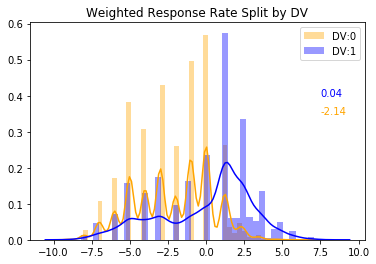

In [34]:
Features["WRR_EMERG"].loc[Features["DV"]==0]

for i in range(0,2):
    sns.distplot((Features["WRR_EMERG"].loc[Features["DV"]==i].values), label="DV:"+str(i), color=Colour_Dict.get(i))
    plt.text(7.5 , 0.25+((i+2)*0.05),str("{:.2f}".format(Features["WRR_EMERG"].loc[Features["DV"]==i].mean() , 0 )), color=Colour_Dict.get(i))
    
plt.title("Weighted Response Rate Split by DV")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

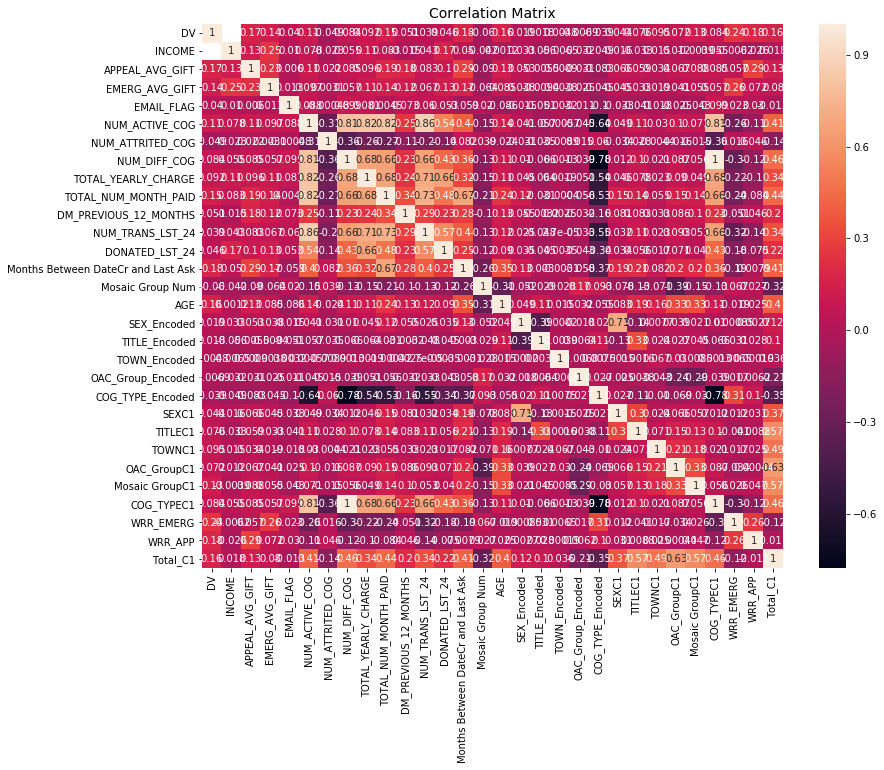

In [35]:
plt.figure(figsize=(13,10))
sns.heatmap(Features.corr(), annot=True)
plt.title("Correlation Matrix", fontsize=14)

Text(0.5, 1.0, 'DV Correlation with Features')

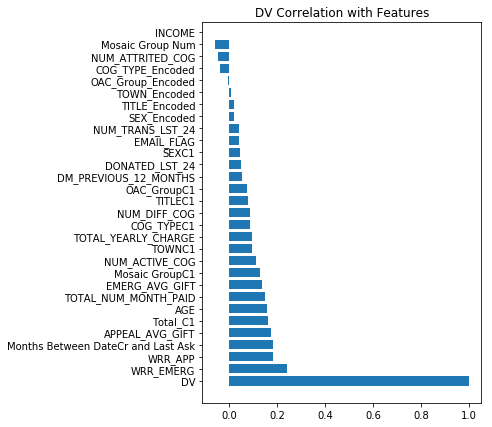

In [36]:
DV_Corr = Features.corr()["DV"].sort_values(ascending =False)

plt.figure(figsize=(5,7))
plt.barh(DV_Corr.index, DV_Corr.values)
plt.title("DV Correlation with Features")

In [37]:
Features.to_csv("Data/Train_Data_Aft_FE.csv")

In [38]:
with open('Parameter_Dictionary/Para_Dict.pickle', 'wb') as handle:
    pickle.dump(parameter_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)